In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data_energy = pd.read_csv('data_energy.csv')

In [3]:
data_weather = pd.read_csv('data_weather.csv')

In [5]:
data_weather['date']  = pd.to_datetime(data_weather['date'], format='%Y%m%d')

#### data cleaning

In [6]:
data_weather.isnull().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

In [7]:
def fill_with_avg(row):
    if pd.isna(row['snow_depth']):
        prev_day = row.name - 1
        next_day = row.name + 1

        prev_value = data_weather.at[prev_day, 'snow_depth'] if prev_day in data_weather.index else None
        next_value = data_weather.at[next_day, 'snow_depth'] if next_day in data_weather.index else None

        if pd.notna(prev_value) and pd.notna(next_value):
            return (prev_value + next_value) / 2
        elif pd.notna(prev_value):
            return prev_value
        elif pd.notna(next_value):
            return next_value
        else:
            return 0
    else:
        return row['snow_depth']

data_weather['snow_depth'] = data_weather.apply(fill_with_avg, axis=1)

In [8]:
data_weather.isnull().sum()

date                 0
cloud_cover         19
sunshine             0
global_radiation    19
max_temp             6
mean_temp           36
min_temp             2
precipitation        6
pressure             4
snow_depth           0
dtype: int64

In [9]:
# 1. Use the mean instead of NaN values for pressure
data_weather['pressure'].fillna(data_weather['pressure'].mean(), inplace=True)

# 2. Remove the NaN value of the prescription
data_weather = data_weather.dropna(subset=['precipitation'])

# 3. Use formulas to calculate min_temp, max_temp and mean_temp
def fill_temperatures(row):
    if pd.isnull(row['min_temp']) and pd.notnull(row['max_temp']) and pd.notnull(row['mean_temp']):
        row['min_temp'] = 2 * row['mean_temp'] - row['max_temp']
    elif pd.notnull(row['min_temp']) and pd.isnull(row['max_temp']) and pd.notnull(row['mean_temp']):
        row['max_temp'] = 2 * row['mean_temp'] - row['min_temp']
    elif pd.notnull(row['min_temp']) and pd.notnull(row['max_temp']) and pd.isnull(row['mean_temp']):
        row['mean_temp'] = (row['min_temp'] + row['max_temp']) / 2
    return row

data_weather = data_weather.apply(fill_temperatures, axis=1)


In [10]:

# Delete the remaining rows containing NaN values
data_weather = data_weather.dropna()


In [11]:
data_weather

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...,...
15336,2020-12-27,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,0.0
15337,2020-12-28,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,0.0
15338,2020-12-29,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,0.0
15339,2020-12-30,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,0.0


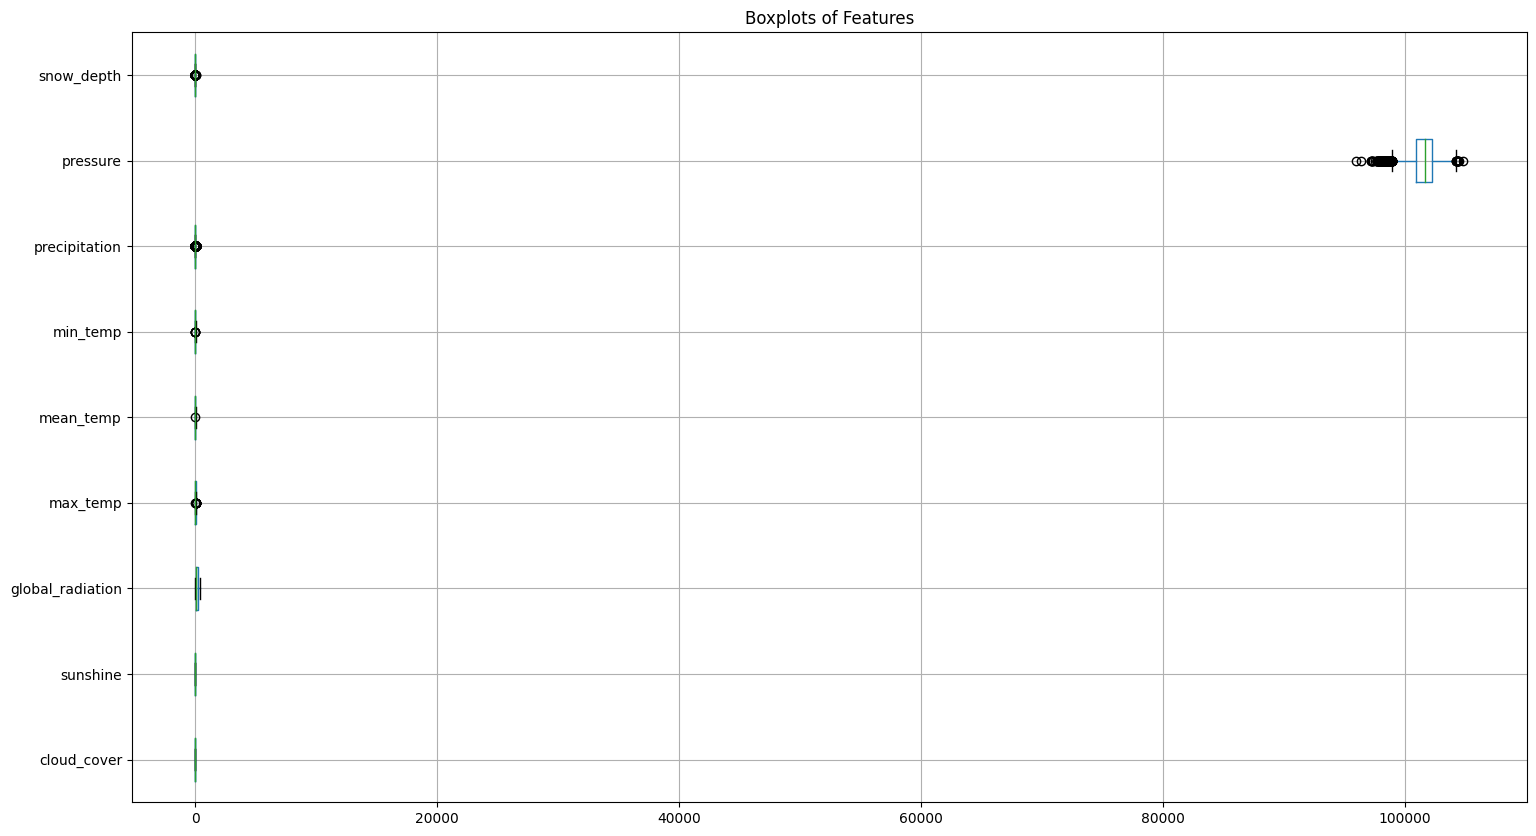

In [12]:

# Plotting boxplots for features to detect outliers
plt.figure(figsize=(18, 10))
data_weather.boxplot(vert=False)
plt.title("Boxplots of Features")
plt.show()

In [14]:
def handle_outliers(df):
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        median_value = df[column].median()
        df[column] = df[column].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)
    
    return df
data_weather = handle_outliers(data_weather)

In [15]:
# Convert to date type
data_weather['date'] = pd.to_datetime(data_weather['date'])

# Create new features
data_weather['year'] = data_weather['date'].dt.year
data_weather['month'] = data_weather['date'].dt.month
data_weather['day'] = data_weather['date'].dt.day
data_weather['weekday'] = data_weather['date'].dt.weekday

# Delete the original 'date' column
data_weather = data_weather.drop('date', axis=1)


In [16]:
data_weather

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,year,month,day,weekday
0,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,0.0,1979,1,1,0
1,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,0.0,1979,1,2,1
2,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,0.0,1979,1,3,2
3,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,0.0,1979,1,4,3
4,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,0.0,1979,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15336,1.0,0.9,32.0,7.5,7.5,7.6,2.0,101620.0,0.0,2020,12,27,6
15337,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,101620.0,0.0,2020,12,28,0
15338,7.0,0.0,21.0,4.1,2.6,1.1,0.0,101620.0,0.0,2020,12,29,1
15339,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,0.0,2020,12,30,2


In [17]:
data_weather_encoded =data_weather

In [18]:

data_weather_encoded.to_csv('data_weather_encoded.csv', index=False)

In [19]:
data_weather_encoded

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,year,month,day,weekday
0,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,0.0,1979,1,1,0
1,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,0.0,1979,1,2,1
2,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,0.0,1979,1,3,2
3,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,0.0,1979,1,4,3
4,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,0.0,1979,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15336,1.0,0.9,32.0,7.5,7.5,7.6,2.0,101620.0,0.0,2020,12,27,6
15337,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,101620.0,0.0,2020,12,28,0
15338,7.0,0.0,21.0,4.1,2.6,1.1,0.0,101620.0,0.0,2020,12,29,1
15339,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,0.0,2020,12,30,2


In [14]:
def create_lagged_features(df, lag_count):
    weather_params = ["cloud_cover", "sunshine", "global_radiation", "max_temp", 
                      "mean_temp", "min_temp", "precipitation", "pressure", 
                      "snow_depth", "mean_temp_prev_day", "year", "day", 
                      "weekday", "quarter_Q1", "quarter_Q2", "quarter_Q3", "quarter_Q4"]
    
    for wp in weather_params:
        for i in range(1, lag_count + 1):
            df[f'{wp}_lag_{i}'] = df[wp].shift(i)
    df = df.iloc[lag_count:]
    return df

lag_count = 20  # Set the lag days to 20
data_weather_encoded_lagged = create_lagged_features(data_weather_encoded, lag_count)

# Split training and test sets
X = data_weather_encoded_lagged.drop(["cloud_cover", "sunshine", "global_radiation", "max_temp", 
                      "mean_temp", "min_temp", "precipitation", "pressure", 
                      "snow_depth", "mean_temp_prev_day", "year", "day", 
                      "weekday", "quarter_Q1", "quarter_Q2", "quarter_Q3", "quarter_Q4"], axis=1)
y = data_weather_encoded_lagged['mean_temp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


C:\Users\95420\AppData\Local\Temp\ipykernel_10232\1054033375.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{wp}_lag_{i}'] = df[wp].shift(i)
C:\Users\95420\AppData\Local\Temp\ipykernel_10232\1054033375.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{wp}_lag_{i}'] = df[wp].shift(i)
C:\Users\95420\AppData\Local\Temp\ipykernel_10232\1054033375.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

KeyError: 'mean_temp_prev_day'